In [3]:
# adding paths to importing things from "data" and "functions and methods" directories.
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))

In [ ]:
from bs4 import BeautifulSoup
import requests

from lisc import Counts
from lisc.utils.db import SCDB
from lisc.utils.io import save_object
from lisc.plts.counts import Counts, plot_matrix

import pandas as pd

from data.lisc_db.terms.terminology import stages, waves, eeg_features_2, additional_features
import matplotlib.pyplot as plt

from wordcloud import WordCloud, get_single_color_func
import copy

# **First, what are some memory concepts in "Working Memory" Literature?**
We'll use concepts from the Cognitive Atlas - https://www.cognitiveatlas.org

In [79]:
url = "https://www.cognitiveatlas.org/concepts/categories/all"
page = requests.get(url)
data = page.text
soup = BeautifulSoup(data, 'html.parser')

# Let's cut down html into the categories of concepts
page_content = soup.find('div', id='pagecontent')
categories = page_content.find_all('h3')
categories = list(enumerate([category.get_text() for category in categories]))
categories

[(0, 'Classified under Action'),
 (1, 'Classified under Attention'),
 (2, 'Classified under Emotion'),
 (3, 'Classified under Executive/Cognitive Control'),
 (4, 'Classified under Language'),
 (5, 'Classified under Learning and Memory'),
 (6, 'Classified under Motivation'),
 (7, 'Classified under Perception'),
 (8, 'Classified under Reasoning and Decision Making'),
 (9, 'Classified under Social Function')]

In [80]:
# Select which category by index
category_idx = 5

category = soup.find(string=categories[category_idx][1]).parent
concepts = category.find_next_sibling('div').find_all('a')
concepts = [term.get_text() for term in concepts]

# Print the first 10 concepts from the selected category
print(concepts)

['reinforcement learning', 'place maintenance', 'visual place recognition', 'working memory updating', 'word maintenance', 'tool maintenance', 'string maintenance', 'pattern maintenance', 'object maintenance', 'body maintenance', 'spontaneous recovery', 'conceptual category', 'priming', 'proactive interference', 'category learning', 'metacognitive skill', 'auditory encoding', 'active retrieval', 'articulatory rehearsal', 'source memory', 'episodic learning', 'context memory', 'long-term memory', 'primary memory', 'consolidation', 'adaptation', 'reconsolidation', 'retention', 'visual memory', 'deep processing', 'knowledge', 'intermediate-term memory', 'retroactive interference', 'instrumental learning', 'recognition', 'elaborative rehearsal', 'skill acquisition', 'forgetting', 'association learning', 'autobiographical memory', 'iconic memory', 'sensory memory', 'perceptual learning', 'explicit memory', 'episodic memory', 'motor learning', 'tactile working memory', 'habit memory', 'phono

In [81]:
# Remove some words that aren't productive.
remove = ['memory', 'skill', 'learning', 'knowledge']
concepts = [concept for concept in concepts if concept not in remove]

### **Now that we have our Learning and Memory concepts in a list, let's run co-occurances with "working memory"**

In [83]:
# initialize lisc SCDB (database) object.
db = SCDB('lisc_db')
db.gen_paths()

In [256]:
# Run co-occurances of "working memory" to the concepts
terms_a = ["working memory"]
terms_b = sorted(concepts) # alphabetical order

counts = Counts()
counts.add_terms(terms_a, dim='A')
counts.add_terms(terms_b, dim='B')
counts.run_collection()

In [9]:
# Save a LISC object into DB
#########################################################################

# absolute path to project directory '../GitHub/Predict-Sleep-EEG/'.
main_dir = os.path.dirname(os.getcwd())

# absolute path to Level 2: Data directory 'data/lisc_db/data/counts/'.
db_dir = os.path.join(main_dir, r'data/' + db.get_folder_path('counts'))

# save lisc data object in db_dir path.
save_object(counts, 'wm-memory.p', directory=db_dir)

### **Co-occurance Graph "Working Memory" to Memory Terms**

In [137]:
# Load a lisc object from DB
########################################################################

# absolute path to project directory '../GitHub/Predict-Sleep-EEG/'.
main_dir = os.path.dirname(os.getcwd())

# relative path to lisc object in database 'data/lisc_db/data/counts/counts.p'
data_rpath = db.get_file_path('counts', 'wm-memory.p')

# absolute path to lisc object.
data_abpath = os.path.join(main_dir, r'data/' + data_rpath)

# load lisc Counts() object with pandas.
pickle1 = pd.read_pickle(data_abpath)

In [138]:
# Compute the normalized similarity scores
pickle1.compute_score('normalize', dim='A')

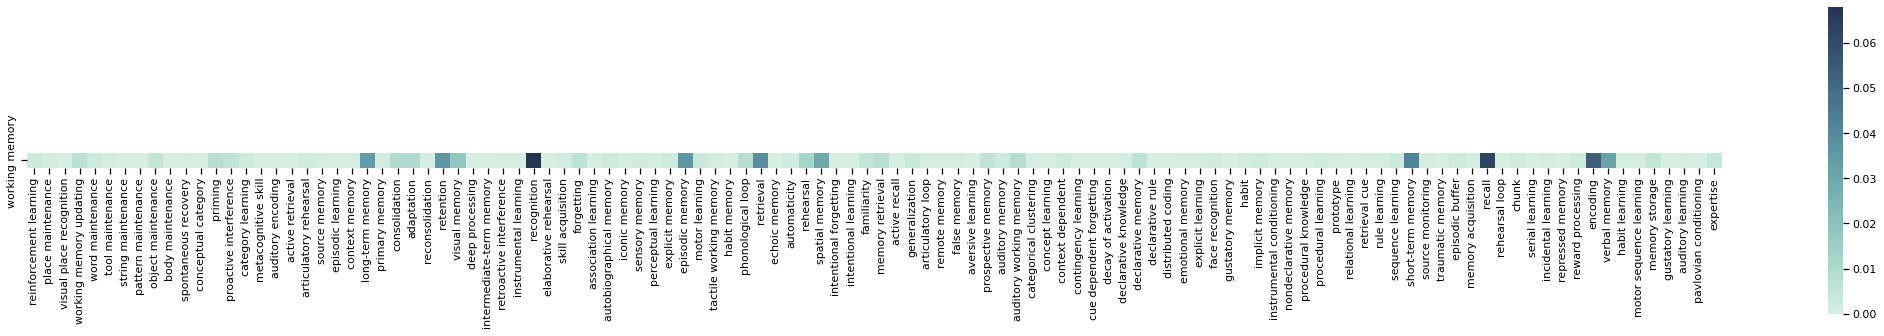

In [133]:
plot_matrix(pickle1, attribute='score', cmap='blue', figsize=(30, 5), square=True) # kwargs sent to seaborn

In [89]:
# LISC's wordcloud function won't suffice so we'll do it ourselves.
###################################################################

# Compile the words and frequencies into a dictionary to pass into the WordCloud object.
# Conveniently, our data is already 1D.
Dict = {}
for word, score in zip(pickle1.terms['B'].terms, pickle1.score[0]):
    Dict[word[0]] = score

(-0.5, 2559.5, 1439.5, -0.5)

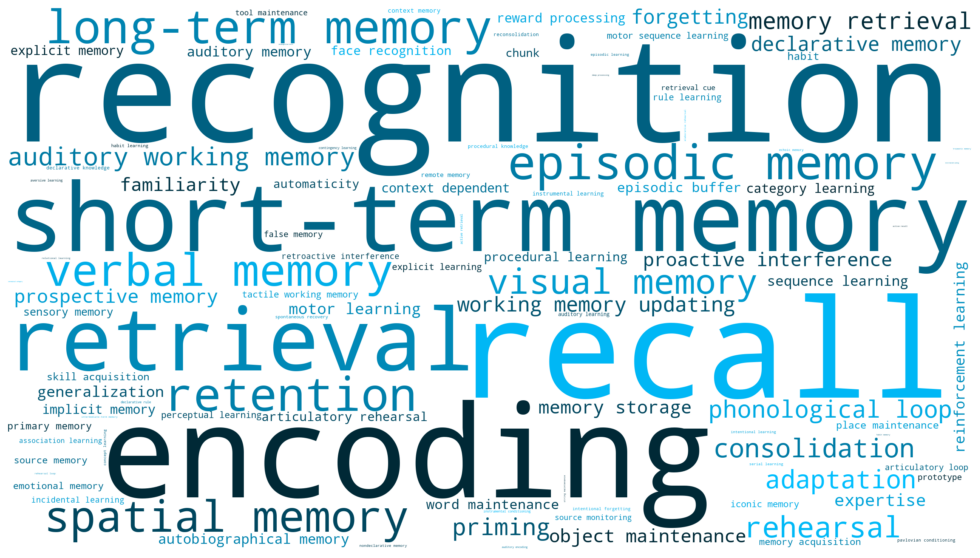

In [60]:
# Tweak the parameters to produce a beautiful wordcloud.
wc = WordCloud(width=2560, height=1440, background_color='white').fit_words(Dict)
color_func1 = get_single_color_func('deepskyblue')

plt.figure(figsize=(18,10))
plt.imshow(wc.recolor(color_func=color_func1), interpolation='bilinear')
plt.axis('off')

## **Let's see what "EEG features" co-occur with "learning and memory"** 

In [19]:
terms_c = terms_b
terms_d = [wave + ' ' + feature for wave in waves for feature in eeg_features_2] + additional_features
terms_d.remove('slow wave')

counts_2 = Counts()
counts_2.add_terms(terms_c, dim='A')
counts_2.add_terms(terms_d, dim='B')
counts_2.run_collection()

In [35]:
main_dir = os.path.dirname(os.getcwd())
db_dir = os.path.join(main_dir, r'data/' + db.get_folder_path('counts'))
save_object(counts_2, 'wm-eeg.p', directory=db_dir)

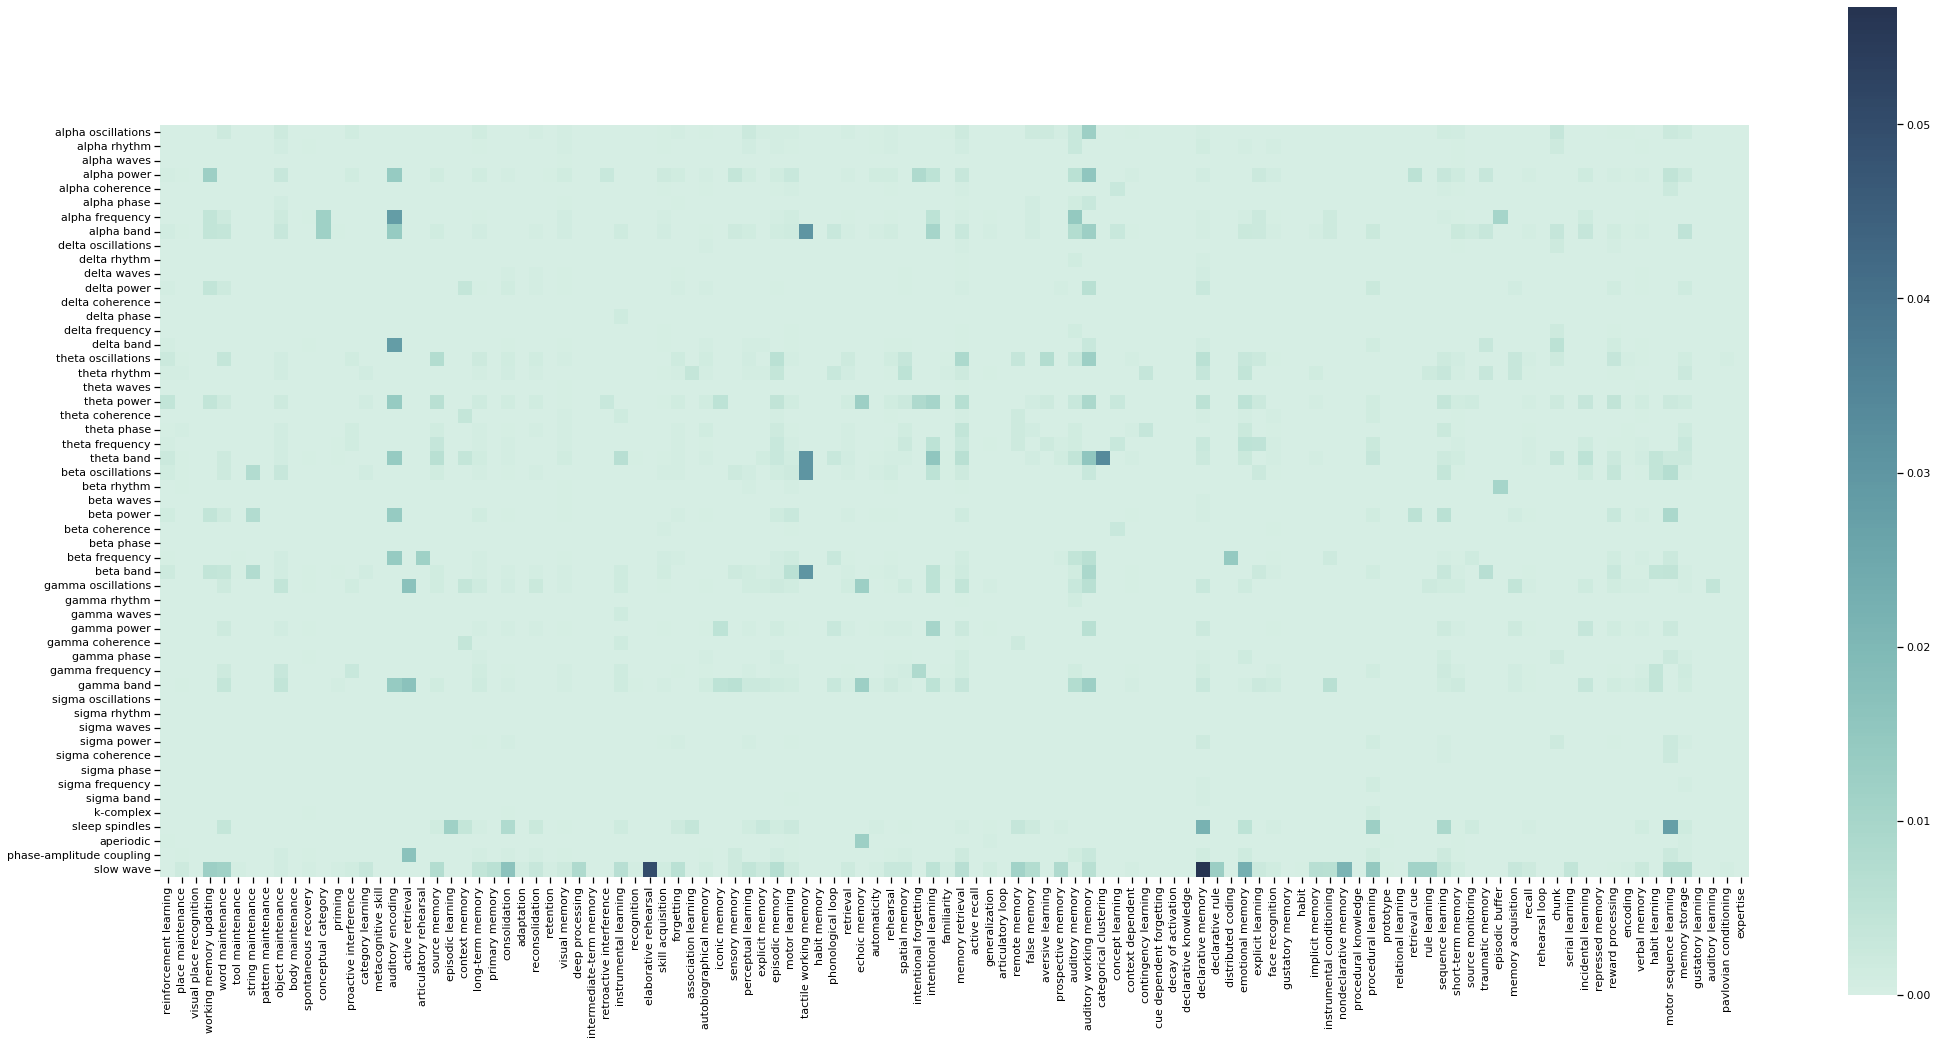

In [294]:
main_dir = os.path.dirname(os.getcwd())
data_rpath = db.get_file_path('counts', 'wm-eeg.p')
data_abpath = os.path.join(main_dir, r'data/' + data_rpath)
pickle2 = pd.read_pickle(data_abpath)

pickle2.compute_score('normalize', dim='A')
plot_matrix(pickle2, attribute='score', cmap='blue', transpose=True, figsize=(30, 15), square=True)

## **Perhaps this is too broad. Let's find cooccurances between "working memory" exclusively and "EEG features".**

In [396]:
def pick_top(counts, top_n:int=None, percentile:float=None):
    counts = copy.deepcopy(counts)
    len_A = len(counts.terms['A'].terms)
    len_B = len(counts.terms['B'].terms)

    top = []
    if top_n:
        percentile = 0
    for i in range(len_A):
        for j in range(len_B):
            if counts.score[i][j] > counts.score.max() * percentile:
                top.append([counts.terms['A'].terms[i][0], counts.terms['B'].terms[j][0], counts.score[i][j]])

    top = sorted(top, key=lambda x: x[2], reverse=True)
    if top_n:
        top = top[:top_n]
    return top 

In [410]:
pd.DataFrame(pick_top(pickle1, top_n=10))

,0,1,2
0,working memory,recognition,0.067983
1,working memory,recall,0.062469
2,working memory,encoding,0.054061
3,working memory,short-term memory,0.042703
4,working memory,retrieval,0.039146
5,working memory,episodic memory,0.036528
6,working memory,retention,0.035480
7,working memory,long-term memory,0.034625
8,working memory,verbal memory,0.031758
9,working memory,spatial memory,0.029911


(-0.5, 2559.5, 1439.5, -0.5)

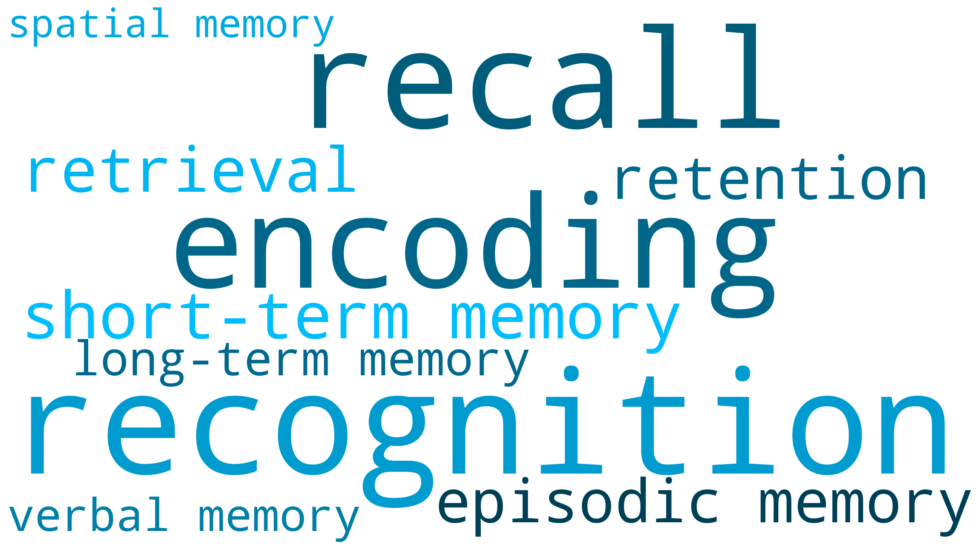

In [406]:
Dict = {}
for word, score in zip(pickle1.terms['B'].terms, pickle1.score[0]):
    Dict[word[0]] = score

wc = WordCloud(width=2560, height=1440, max_words=10, background_color='white').fit_words(Dict)
color_func1 = get_single_color_func('deepskyblue')

plt.figure(figsize=(18,10))
plt.imshow(wc.recolor(color_func=color_func1), interpolation='bilinear')
plt.axis('off')

# **Now that we have our top terms for "working memory", let's run cooccurances against "EEG features".**

In [414]:
terms_e = list(zip(*pick_top(pickle1, top_n=10)))[1]
terms_f = [wave + ' ' + feature for wave in waves for feature in eeg_features_2] + additional_features
terms_f.remove('slow wave')

counts3 = Counts()
counts3.add_terms(terms_e, dim='A')
counts3.add_terms(terms_f, dim='B')
counts3.run_collection()

In [415]:
main_dir = os.path.dirname(os.getcwd())
db_dir = os.path.join(main_dir, r'data/' + db.get_folder_path('counts'))
save_object(counts3, 'wm-eeg (1).p', directory=db_dir)

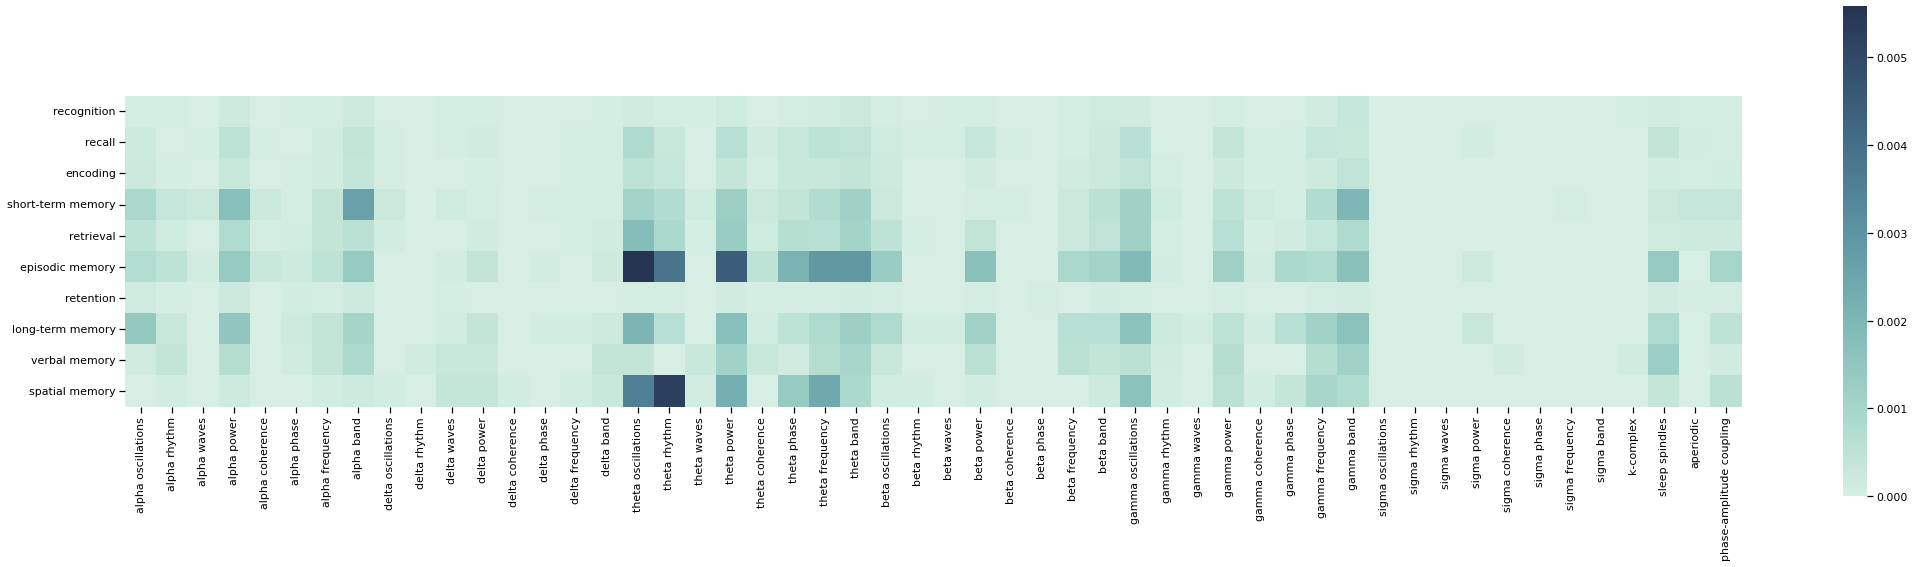

In [421]:
main_dir = os.path.dirname(os.getcwd())
data_rpath = db.get_file_path('counts', 'wm-eeg (1).p')
data_abpath = os.path.join(main_dir, r'data/' + data_rpath)
pickle3 = pd.read_pickle(data_abpath)

pickle3.compute_score('normalize', dim='A')
plot_matrix(pickle3, attribute='score', cmap='blue', figsize=(30, 8), square=True)

# **Finally, what about cooccurances between "stages of sleep" and "working memory?"**

In [424]:
terms_g = stages
terms_h = terms_e = list(zip(*pick_top(pickle1, top_n=10)))[1]

counts4 = Counts()
counts4.add_terms(terms_g, dim='A')
counts4.add_terms(terms_h, dim='B')
counts4.run_collection()

In [425]:
main_dir = os.path.dirname(os.getcwd())
db_dir = os.path.join(main_dir, r'data/' + db.get_folder_path('counts'))
save_object(counts4, 'wm-sleep.p', directory=db_dir)

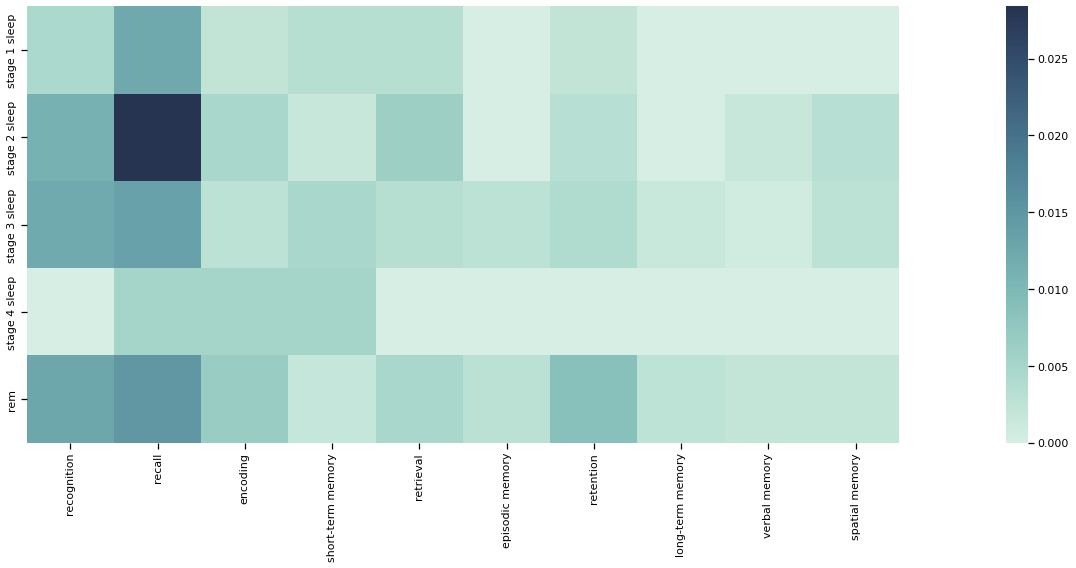

In [426]:
main_dir = os.path.dirname(os.getcwd())
data_rpath = db.get_file_path('counts', 'wm-sleep.p')
data_abpath = os.path.join(main_dir, r'data/' + data_rpath)
pickle4 = pd.read_pickle(data_abpath)

pickle4.compute_score('normalize', dim='A')
plot_matrix(pickle4, attribute='score', cmap='blue', figsize=(30, 8), square=True)